# Udacity Self Driving Car Engineer Nanodegree Project 4

##  Advanced Lane Finding

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an(or several) annotated video which identifies:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### import useful dependencies

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

from moviepy.editor import VideoFileClip
from collections import deque

%matplotlib inline

### Step 1: Camera Calibration given a set of chessboard images
The camera calibration matrix and distortion coefficients are calculated by calling OpenCV helper functions: cv2.findChessboardCorners()and cv2.drawChessboardCorners().

output_images/calibration10.jpg
output_images/calibration11.jpg
output_images/calibration12.jpg
output_images/calibration13.jpg
output_images/calibration14.jpg
output_images/calibration15.jpg
output_images/calibration16.jpg
output_images/calibration17.jpg
output_images/calibration18.jpg
output_images/calibration19.jpg
output_images/calibration2.jpg
output_images/calibration20.jpg
output_images/calibration3.jpg
output_images/calibration6.jpg
output_images/calibration7.jpg
output_images/calibration8.jpg
output_images/calibration9.jpg


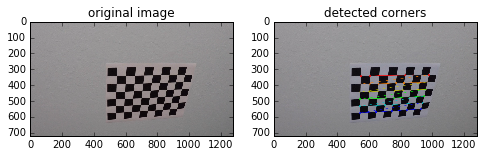

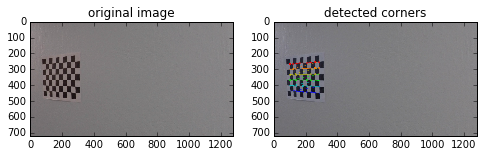

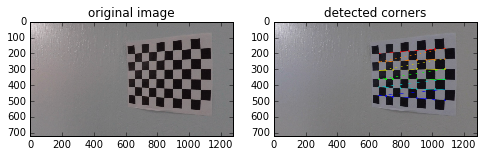

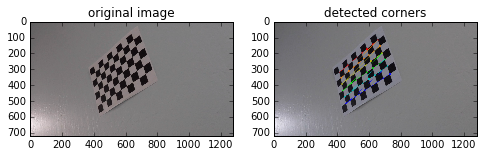

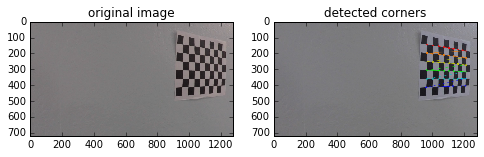

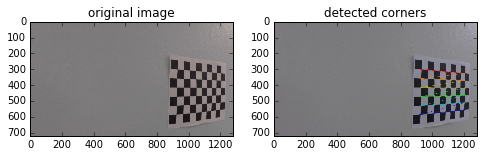

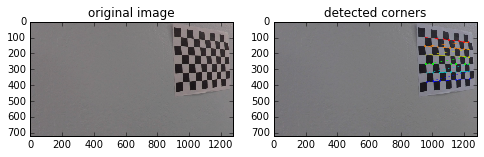

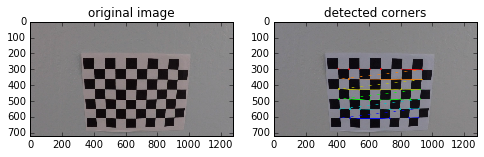

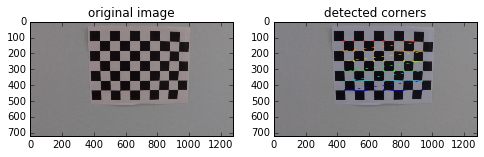

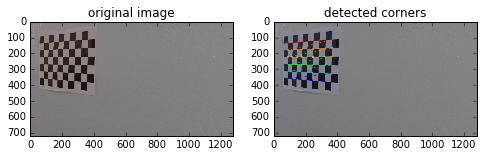

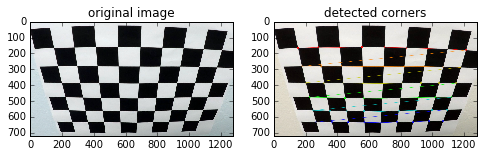

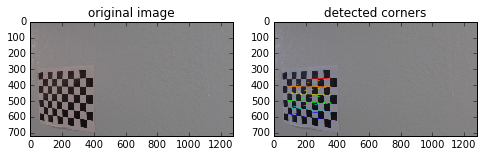

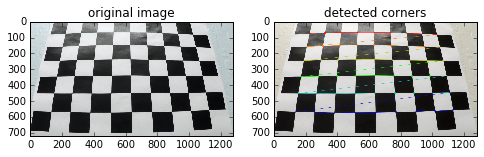

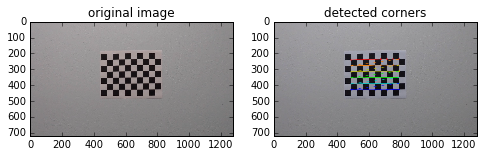

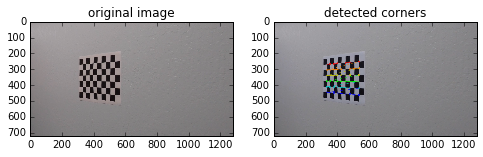

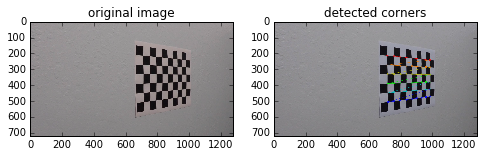

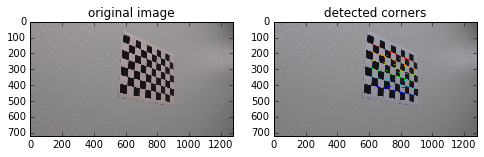

In [2]:
# implementing the camera calibration by calling opencv helper functions 
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# 3D object points in real-world scenes
objpoints = []
# 2D image points in image plane
imgpoints = []

# loading the given chessboard images in folder called 'camera_cal'
images = glob.glob('camera_cal/calibration*.jpg')

for idx,filename in enumerate(images):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # find the chessboard corners
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # draw the corners in the original image
        cv2.drawChessboardCorners(img,(9,6),corners,ret)
        fig,axes = plt.subplots(1,2,figsize = (8,4))
        axes[0].imshow(cv2.cvtColor(mpimg.imread(filename),cv2.COLOR_BGR2RGB))
        axes[0].set_title('original image',fontsize = 12)
        axes[1].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        axes[1].set_title('detected corners',fontsize = 12) 
        
        print(os.path.join('output_images/',os.path.split(filename)[1]))        
        # print(type(fig)), and type(fig) = <class 'matplotlib.figure.Figure'>

        fig.savefig(os.path.join('output_images/',os.path.split(filename)[1]))
        #cv2.imwrite(os.path.join('output_images/',os.path.split(filename)[1]),img)

### ** My notes:** 
- In folder named camera_cal there are 20 given images. However, I only did camera calibration with 17 images successfully and the results are saved in output_images folder. After analyzing the failed original 'calibration1.jpg','calibration4.jpg' and 'calibration5.jpg', they have the same problem: the distortions are too severe so cv2.findChessboardCorners() can't detect enough (9,6)corners in x and y directions. Thus there are only 17 successful detected images stored in output_images folder.
- There are two ways to save the images with detected corners: cv2.imwrite()and matplotlib.figure.Figure.figsave(), and I chose the latter because fig.figsave()can save the original image and 'detected-corners' image as a whole image file once, while cv2.imwrite()can only save one 'detected-corners' image once.

### Step 2: Distortion Correction on raw images
Here the distortion correction on raw images can be realized by building a function named undistort() which uses the calculated camera calibration matrix and distortion coefficients. And the undistorted images are saved in output_images folder, too.

In [3]:
# distortion correction
def undistort(filename, show = True, read = True):
    if read:
        img = cv2.imread(filename)
        
    img_size = (img.shape[1],img.shape[0])
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    if show:
        fig,axes = plt.subplots(1,2,figsize =(8,4))
        axes[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        axes[0].set_title('original image',fontsize = 12)
        axes[1].imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
        axes[1].set_title('undistorted image', fontsize = 12)
        fig.savefig(os.path.join('output_images','undistorted_'+os.path.split(filename)[1]))
    else:
        return undist    

test_images\straight_lines1.jpg
test_images\straight_lines2.jpg
test_images\test1.jpg
test_images\test2.jpg
test_images\test3.jpg
test_images\test4.jpg
test_images\test5.jpg
test_images\test6.jpg


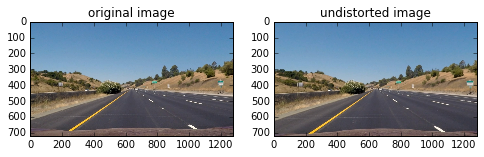

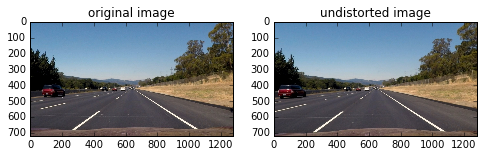

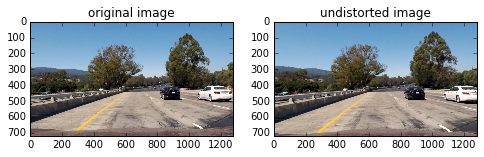

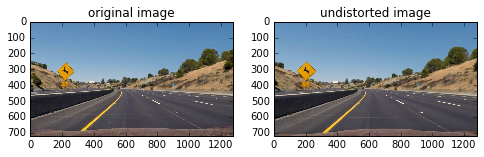

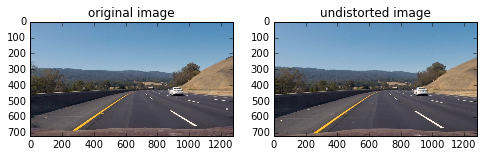

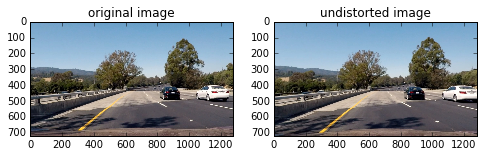

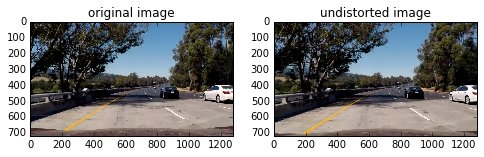

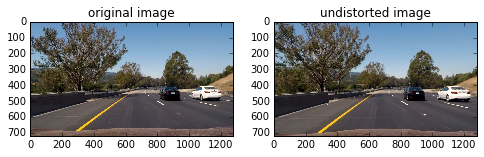

In [4]:
images = glob.glob('test_images/*.jpg')
#print(images)

for idx,filename in enumerate(images):
    print(filename)
    undistort(filename)

#### **My notes:**
Comparing the original images and the corresponding undistorted images, especially in the edge regions of camera, you can see the differences produced by radial and translational cameara distortion. And in real world we usually ignore these distortions. 

##  Pipeline to a single image/frame
**My notes:** As the [udacity courses](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/44732d48-dcfe-4b4e-9614-12422ec29306) says, the pipeline for advanced laneline finding includes eight steps:

- step1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- step2: Apply a distortion correction to raw images.
- step3: Use color transforms, gradients, etc., to create a thresholded binary image.
- step4: Apply a perspective transform(warping) to rectify binary image ("birds-eye view").
- step5: Detect lane pixels and fit to find the lane boundary.
- step6: Determine the curvature of the lane and vehicle position with respect to center.
- step7: Warp the detected lane boudaries back into original image
- step8: Output visual display of the lane boundaries and numerical estimationof lane curvature and vehicle position.

However, after lots of trials and errors, instead of implementing color/gradient thresholds on the whole images and then warping the regions of interest(yellow and white lanelines), I think step 3 and step 4 can be exchanged optionally. And there are mainly two reasons to do this:

- 1.from the view of image processing, after perspective transform, the output images are easier and more focused on the regions of interest(yellow and white laneline regions), which is helpful for further detection and curvature calculation.
- 2.from the view of gradient thresholding, after perspecive transform, the highlighted yellow and white lanelines are almost vertical in the warped images, which is helpful for determining the gradient threshold, instead of lots of experiments.

### Step 3 (original step 4): Applying a perspective transform(warping) to an undistorted image
The perspective transform,i.e.warping can be implemented by constructing a function named birds_eye_view(). Although perspective transform can be done between undistorted images and warped images through any possible viewpoints, a bird's-eye view of the road can help to show the lanelines almost in parallel to each other, which is very useful for further processing: combined color/gradient thresholding, laneline detection and curvature calculation.  

In [5]:
# implementing a bird's eye view using perspective transform
def birds_eye_view(filename, show = True, read = True):
    if read:
        undist = undistort(filename, show = False)
    else:
        undist = undistort(filename, show = False, read = False)
    
    img_size = (undist.shape[1],undist.shape[0])
    offset = 0
    
    # define four source points and destination points, and determined them in the test straight_lines1.jpg
    src = np.float32([[490,482], [810,482],[1250,720],[40,720]])
    dst = np.float32([[0,0],[1280,0],[1280,720],[40,720]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(undist,M,img_size)
    
    if show:
        fig,axes = plt.subplots(1,2,figsize =(8,4))
        fig.tight_layout()
        
        axes[0].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        axes[0].set_title('undistorted image',fontsize = 12)
        axes[1].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        axes[1].set_title('undistorted and warped image',fontsize = 12)
        #fig.savefig(os.path.join('output_images','undistorted_and_warped_'+os.path.split(filename)[1]))
        #plt.subplots_adjust(left = 0.0, right = 1.0, top = 0.9, bottom = 0.0)
    else:
        return warped,M

test_images\straight_lines1.jpg
test_images\straight_lines2.jpg
test_images\test1.jpg
test_images\test2.jpg
test_images\test3.jpg
test_images\test4.jpg
test_images\test5.jpg
test_images\test6.jpg


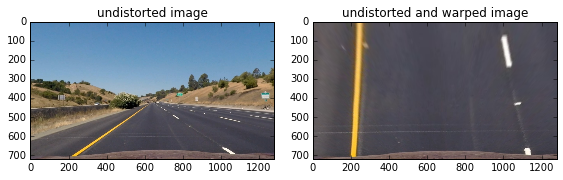

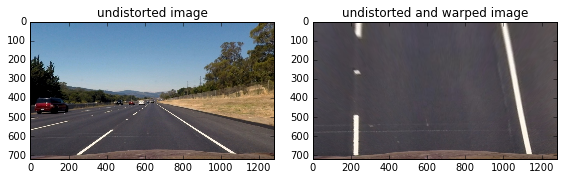

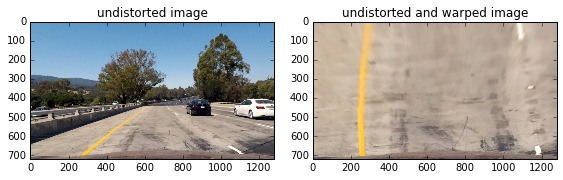

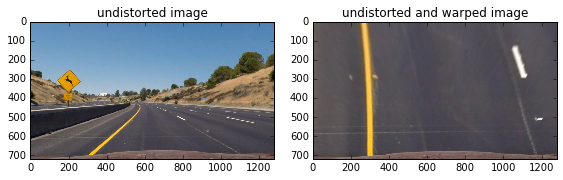

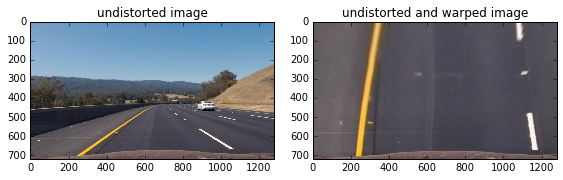

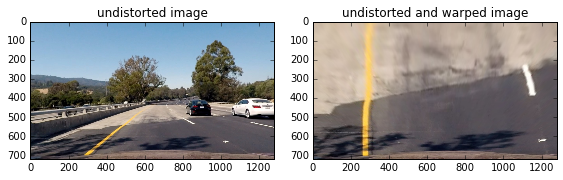

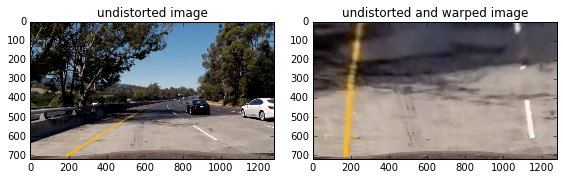

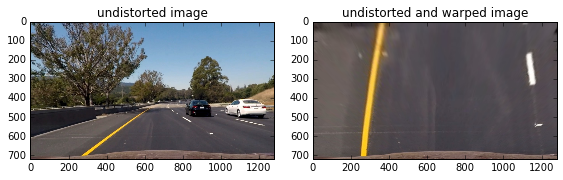

In [6]:
images = glob.glob('test_images/*.jpg')
#print(images)

for idx,filename in enumerate(images):
    print(filename)
    birds_eye_view(filename)

### Step 4 (original step3): Implementing Color/Gradient threshold to create a combined thresholded binary image
This combined thresholding on color and gradients can be realized by building a function named combined_thresholds().

** color thresholds**

Aside from RGB and HLS colorspaces, courses encourage us to try more different colorspaces like HSV, Lab and LUV, which are mostly inspired by human vision system and/or developed for efficient use in television screen displays and computer graphics. And I did. After trials and errors, I chose the following color channels and thresholds on given test images to create binary color-thresholded images, with highlighted yellow and white lanelines.

* s-channel from HLS colorspace, with threshold [180,255], stays fairly consistent in shadow or excessive brightness for both yellow and white lanelines. However, I observed it cannot detect all the pixels of interest in either of them, so more color channel should be chose to compensate this.
* b-channel from Lab colorspace, with threshold [155,200], works better than S-channel in detecting yellow lanelins, while completely misses the white ones.
* l-channel from LUV colorspace, with threshold [225,255], works better than S-channel in detecting white lanelines,while completely misses the yellow ones.

** gradient thresholds**

Besides the color-thresholded images, I chose sobel filters on s-channel to detect edges of lanelines. After lots of trials and errors, the magnitude of gradient along x and y directions with threshold [50,150] was useful for test images. And the requirement for determining gradient threshold is to detect the most salient regions with the largest gradient without bringing extra noise to the combined color binary images. 

Based on these four channels, here comes the combined thresholded binary images as follows.

In [7]:
# implementing combined thresholding on warped images
def combined_thresholds(filename, show = True):
    img,M = birds_eye_view(filename, show = False)
    
    s_channel = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)[:,:,2]
    b_channel = cv2.cvtColor(img,cv2.COLOR_BGR2Lab)[:,:,2]
    l_channel = cv2.cvtColor(img,cv2.COLOR_BGR2LUV)[:,:,0]
    
    # implementing different thresholds on three color channels
    s_threshold = [180,255]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_threshold[0])&(s_channel <= s_threshold[1])]=1
    
    b_threshold = [155,200]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_threshold[0])&(b_channel <= b_threshold[1])]=1
    
    l_threshold = [225,255]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_threshold[0])&(l_channel <= l_threshold[1])]=1
    
    #color_binary = np.dstack((b_binary,s_binary,l_binary))
    color_binary = np.zeros_like(s_binary)
    color_binary[(b_binary == 1)|(l_binary ==1)]=1
    
    # implementing gradient thresholding on warped images
    # cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(s_channel,cv2.CV_64F,1,0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobel_threshold = [50,150]
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=sobel_threshold[0])&(scaled_sobel<=sobel_threshold[1])]=1    
    
    # get the final combined thresholded binary image
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(color_binary ==1)|(grad_binary==1)]=1
    
    if show == True:
        fig,axes = plt.subplots(2,4,sharey = 'col',sharex = 'row', figsize = (12,6))
        fig.tight_layout()
        #print(axes)
        axes[0][0].imshow(cv2.cvtColor(undistort(filename, show=False),cv2.COLOR_BGR2RGB))
        axes[0][0].set_title('distorted image', fontsize = 10)
        
        axes[0][1].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype('uint8'))
        axes[0][1].set_title('warped image', fontsize = 10)
        
        axes[0][2].imshow(s_binary,cmap = 'gray')
        axes[0][2].set_title('thresholded s_binary', fontsize = 10)
        
        axes[0][3].imshow(b_binary,cmap = 'gray')
        axes[0][3].set_title('thresholded b_binary', fontsize = 10)
        
        axes[1][0].imshow(l_binary,cmap = 'gray')
        axes[1][0].set_title('thresholded l_binary', fontsize = 10)
        
        axes[1][1].imshow(color_binary,cmap = 'gray')
        axes[1][1].set_title('combined color binary', fontsize = 10)
        
        axes[1][2].imshow(grad_binary,cmap ='gray')
        axes[1][2].set_title('thresholded gradient binary', fontsize = 10)
         
        axes[1][3].imshow(combined_binary,cmap ='gray')
        axes[1][3].set_title('combined binary', fontsize = 10)
        # save the results
        #fig.savefig(os.path.join('output_images','combined_thresholded_'+os.path.split(filename)[1]))
    else:
        return combined_binary 

test_images\straight_lines1.jpg
test_images\straight_lines2.jpg
test_images\test1.jpg
test_images\test2.jpg
test_images\test3.jpg
test_images\test4.jpg
test_images\test5.jpg
test_images\test6.jpg


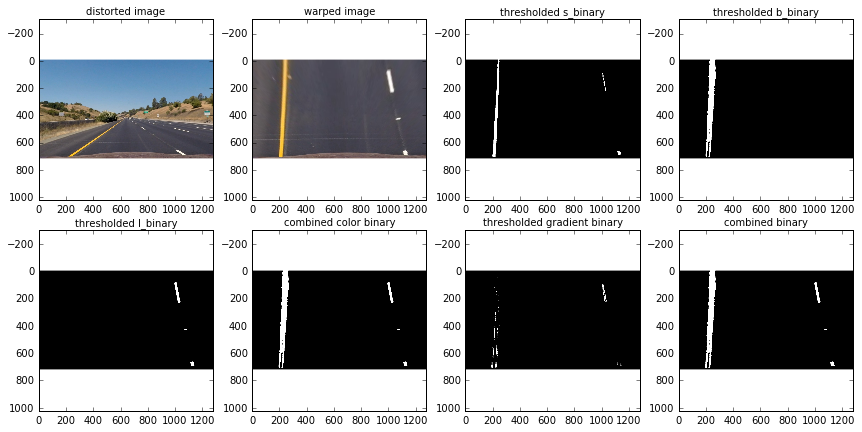

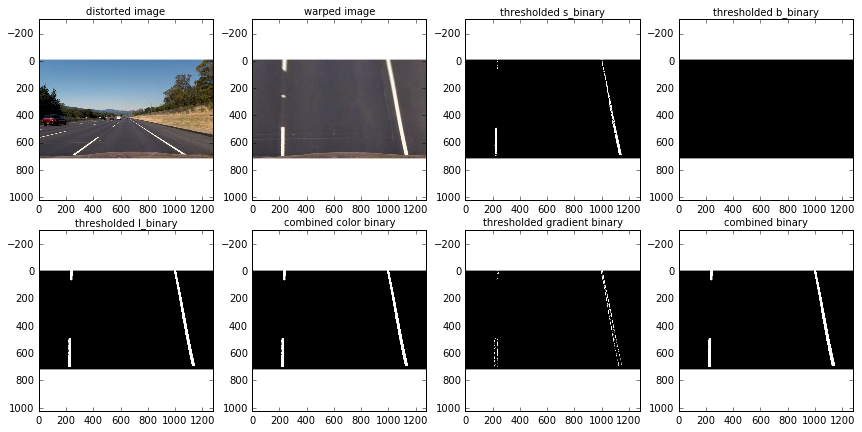

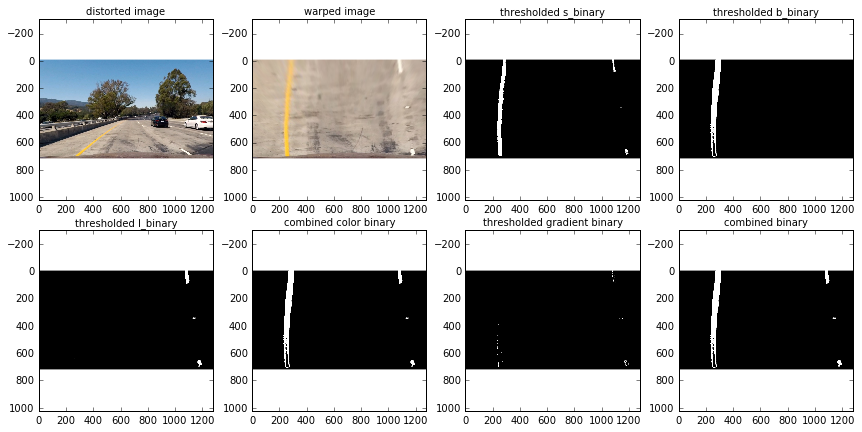

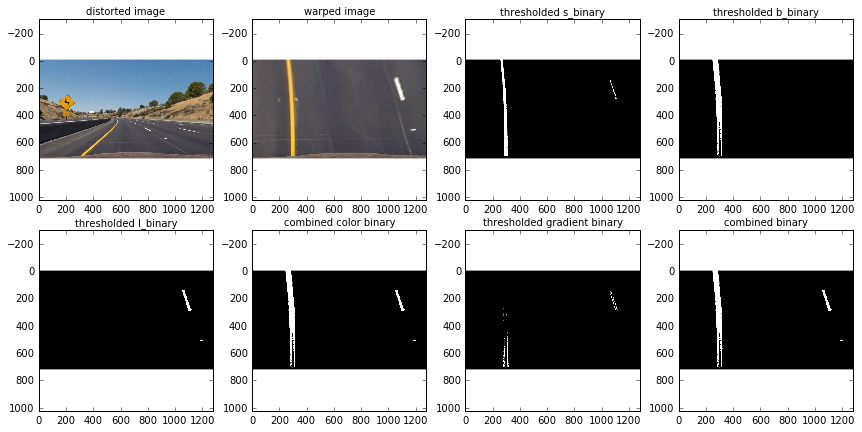

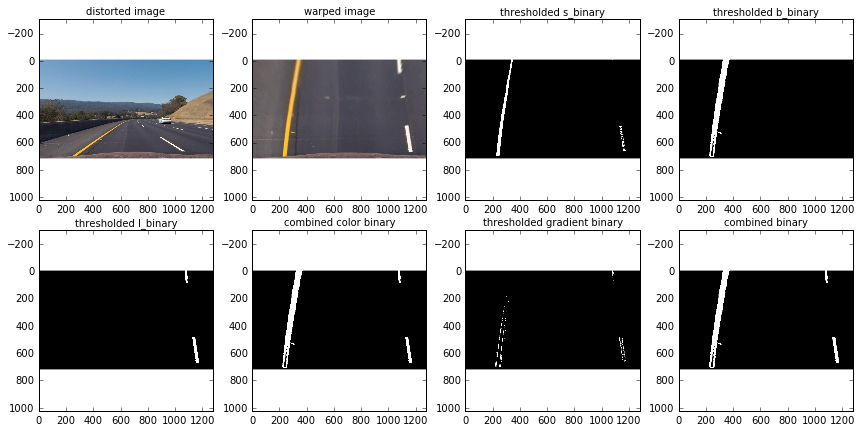

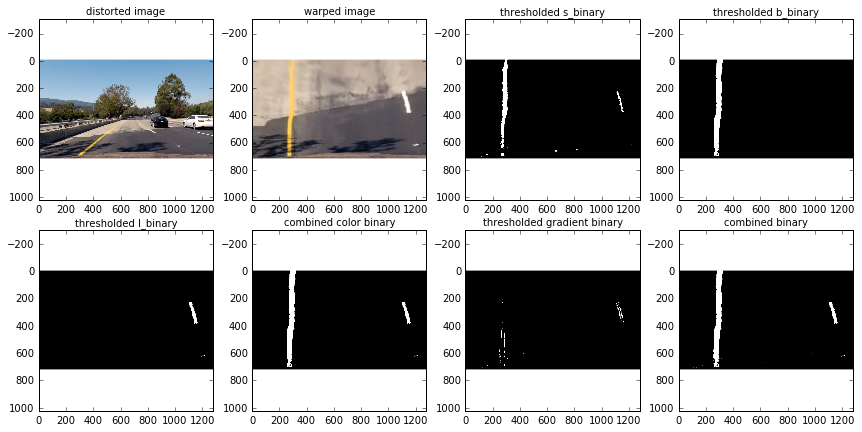

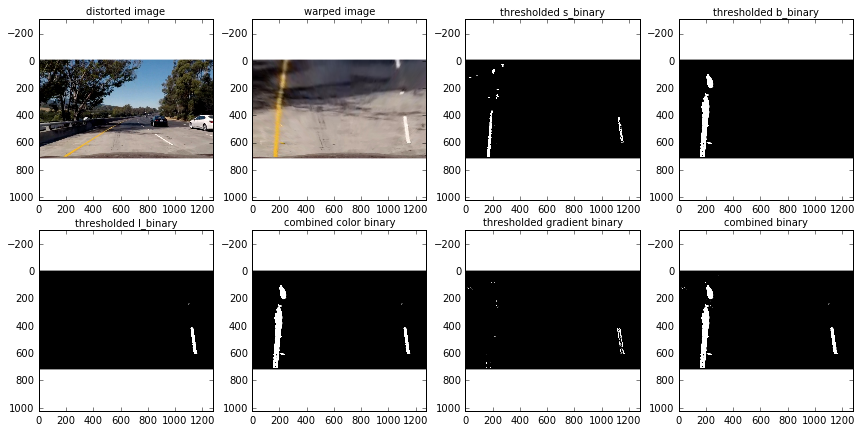

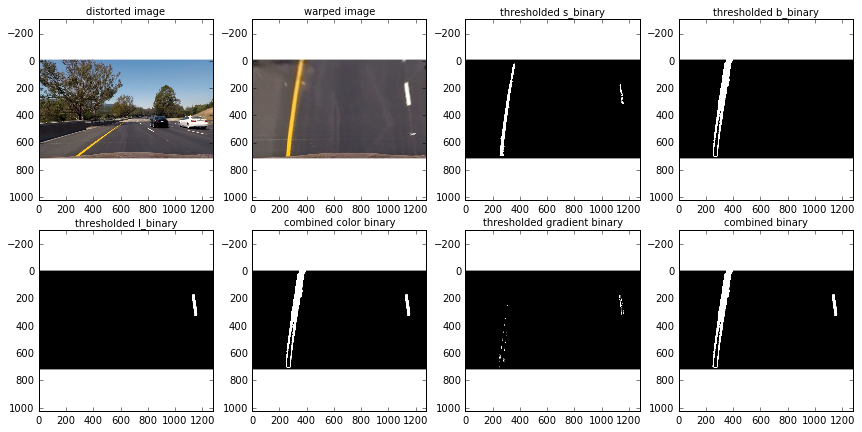

In [8]:
images = glob.glob('test_images/*.jpg')
#print(images)

for idx,filename in enumerate(images):
    print(filename)
    combined_thresholds(filename)

#### **My notes:**
The experiments have proved my thoughts are right about the exchanging of step 3 and 4. And the results are satisfying.

[//]: # (Image References)
[image1]: ./examples/curve_fitting.jpg "curve fitting"
[image2]: ./examples/curvature.jpg "curvature"
[image3]: ./examples/curvature1.jpg

### Step 5: Lane pixels detection and boundary fitting 
From now on I can use the combined-thresholded binary image to detect yellow and white laneline pixels, and fit a polynomial curve for each boundary of them. The driveable region between the two detected lanelines is highlighted with green area.
The laneline detection can be implemented by locating peaks in the histogram of half combined-thresholded binary image, and by detecting nonzero pixels near the peaks.Using the x and y pixel positions to fit a second order polynomial curve:

![alt text][image1]

### Step 6: Calculating lane curvatures and vehicle locations

In this section, after locating the laneline pixels, the laneline curvatures is caluculated according to [course slides](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/2f928913-21f6-4611-9055-01744acc344f) and [curvature formula](http://www.intmath.com/applications-differentiation/8-radius-curvature.php). And the equation for radius of curvature is:

|formula1 |formula2|
|-------------------|--------------------|
|![alt text][image2]| ![alt text][image3]|

The y values of my image increase from top to bottom, so when measuring the radius of curvature closest to the vehicle, the formula above at the y value should be evaluated corresponding to image bottom. Besides, the position of vehicles can be calculated by taking the average of the x intercepts of each line.
### Step 7: Warping detected lane boundaries back to original images

This warping can be implemented by executing the inverse of perspective transform matrx M with exchanging the postions of source points and destination points:
```sh
Minv = cv2.getPerspectiveTransform(dst, src)
```
Then the cv2.warpPerspective()realizes the transform from detected lane boundaries back to the original undistorted images.

All of these step 5,6 and 7 can be implemented by building a function named fill_lanelines()as follows:

In [9]:
def fill_lanelines(filename):
    # introduce the combined_thresholded_binary_images with 1280x720.
    combined_binary = combined_thresholds(filename, show = False)
    
    leftx = []
    lefty = []
    rightx = []
    righty = []
    
    x,y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis = 0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25)< x)&(x<(left_peak+25))&((y>j)&(y<i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window)!= 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())
        
        right_peak = np.argmax(histogram[640:])+640
        x_idx = np.where((((right_peak - 25)<x)&(x<(right_peak +25))&((y>j)&(y<i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window)!=0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90
    
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    # do the polynomial fitting
    left_fit = np.polyfit(lefty,leftx,2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty,rightx,2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty,720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty,0)
    
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx,leftx_int)
    lefty = np.append(lefty,720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty,0)
    
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    
    left_fit = np.polyfit(lefty,leftx,2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty,rightx,2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # calculate the curvature radius for each laneline
    # meters per pixel in y dimension
    ym_per_pix = 30./720 
    # meters per pixel in x dimension
    xm_per_pix = 3.7/700
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix,2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix,2)
    left_curverad = ((1+(2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curvead = ((1+(2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # calculate the position of vehicle
    center = abs(640 - ((rightx_int + leftx_int)/2))
    
    offset = 0
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx,righty]))])
    pts = np.hstack((pts_left,pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed = False, color = (0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    newwarp = cv2.warpPerspective(color_warp, Minv,img_size)
    result = cv2.addWeighted(mpimg.imread(filename), 1, newwarp, 0.5, 0)
    
    fig,axes = plt.subplots(1,2,figsize = (8,4))
    fig.tight_layout()
    axes[0].imshow(cv2.cvtColor((birds_eye_view(filename, show = False)[0]), cv2.COLOR_BGR2RGB))
    axes[0].set_xlim(0,1280)
    axes[0].set_ylim(0,720)
    axes[0].plot(left_fitx, lefty, color = 'green', linewidth = 3)
    axes[0].plot(right_fitx, righty, color = 'green', linewidth = 3)
    axes[0].set_title('Polynomial fitting to lanelines', fontsize = 12)
    axes[0].invert_yaxis()
    
    axes[1].imshow(result)
    axes[1].set_title('Fill lane between polynomials', fontsize = 12)
    if center < 640:
        axes[1].text(200,100,'Vehicle is {:.2f}m left of the center'.format(center*3.7/700),\
                     style = 'oblique',color = 'yellow', fontsize = 10)
    else:
        axes[1].text(200,100,'Vehicle is {:.2f}m right of the center'.format(center*3.7/700),\
                    style = 'oblique', color = 'yellow', fontsize = 10)
    axes[1].text(200,175,'Curvature radius is {}m'.format(int((left_curverad + right_curvead)/2)),\
                style = 'oblique', color = 'yellow', fontsize = 10) 
    #fig.savefig(os.path.join('output_images','fill_lanelines_'+os.path.split(filename)[1]))

### Step 8: Visualizing the advanced laneline finding 
Visualizing the laneline boudaries and the numerical estimation of laneline curvature and vehicle positions.**

test_images\straight_lines1.jpg
test_images\straight_lines2.jpg
test_images\test1.jpg
test_images\test2.jpg
test_images\test3.jpg
test_images\test4.jpg
test_images\test5.jpg
test_images\test6.jpg


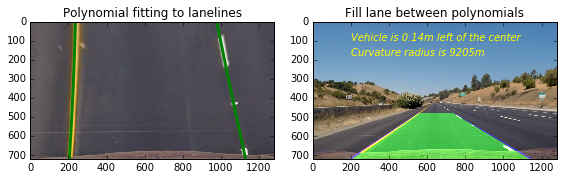

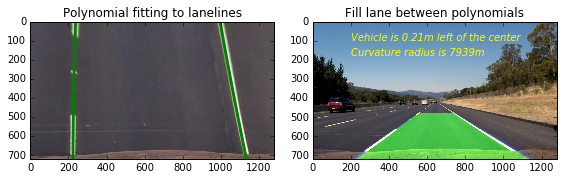

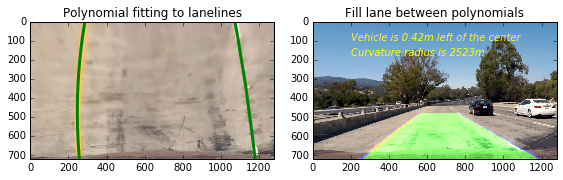

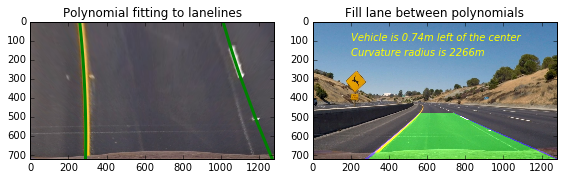

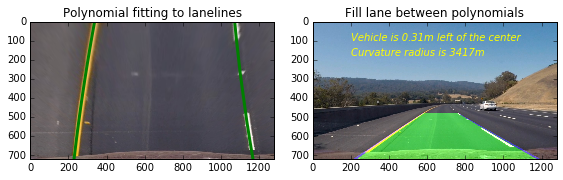

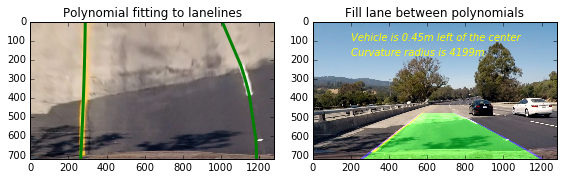

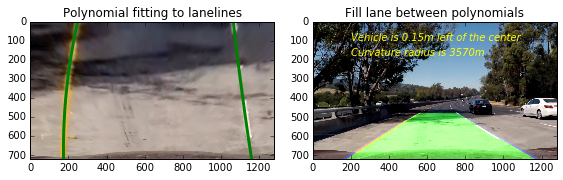

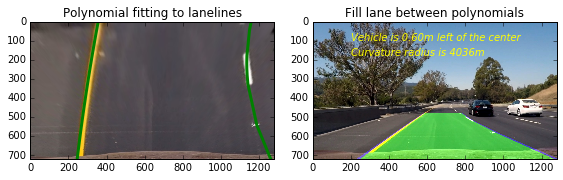

In [10]:
images = glob.glob('test_images/*.jpg')

for idx,filename in enumerate(images):
    print(filename)
    fill_lanelines(filename)

## Pipeline on a test video
In this section, firstly I define a class named Line() as described in udacity courses, where the laneline attributes can be stored from frame to frame. And inside the class, some functions are built to do advanced laneline detection.

Then I built a pipeline function named video_processing(), which will do the similar pipeline fill_lanelines() for frame to frame, instead of a single image. The video_processing includes camera calibration, distortion correction, perspective transform, combined thresholding, laneline detection, curvature calculation and so on. Besides, the difference between these two functions is video_processing() will store information of the lanelines across frames to average the lane positions and produce a robust smooth ouput.

The video_processing() also knows whether the lanelines were detected in the previous frame, and if detected, it only checks for laneline pixels in a tight window around the previous polynomial, ensuring a high confidence detection. And if not detected in the previous frame(or the first five frames), the function will do the same search which was perforemed in fill_lanelines()based on identifying left and right peaks in a histogram of combined-thresholded binary undistored image.

In [11]:
class Line:
    # object initialization
    def __init__(self):
        # the indicater of whether the line found in previous frame
        self.found = False
        
        # remeber x and y values of lanelines in previous frame
        self.X = None
        self.y = None
        
        # store recent x intercepts for averaging among frames
        self.x_int = deque(maxlen = 10)
        self.top = deque(maxlen = 10)
        
        #remember previous x intercepts to compare with current ones
        self.lastx_int = None
        self.lasty_int = None
        
        # remeber curvature radius
        self.radius = None
        
        # store recent polynomial coefficientsw for averaging across frames
        self.fit0 = deque(maxlen = 10)
        self.fit1 = deque(maxlen = 10)
        self.fit2 = deque(maxlen = 10)
        self.fitx = None
        self.pts = []
        
        # count the number of frames
        self.count = 0
  
    # implementing sliding window to search for laneline pixels in close proximity +/- 25 pixels in x direction around
    # the previous detected polynomial curves, when the lanelines have been detected in previous frame.
    def found_search(self,x,y):
        xvals = []
        yvals = []
    
        if self.found == True:
            i = 720
            j = 630
            while j >=0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval-25)<x)&(x<(xval+25))&((y>j)&(y<i))))
                x_window, y_window = x[x_idx], y[x_idx]
                
                if np.sum(x_window)!=0:
                    np.append(xvals,x_window)
                    np.append(yvals,y_window)
                i -= 90
                j -= 90
        if np.sum(xvals)==0:
            # If no lane pixels were detected then perform blind search
            self.found = False
        return xvals,yvals,self.found
    
    # using a sliding window to detect peaks in a histogram of the combined thresholded binary images.
    # And this function is used in the several starting frames. Pixels in close promity to the detected peaks are 
    # considered to belong to lanelines.
    def blind_search(self, x,y,image):
        xvals = []
        yvals = []
        
        if self.found == False:
            i = 720
            j = 630
            while j>= 0:
                histogram = np.sum(image[j:i,:], axis = 0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
            if np.sum(xvals)>0:
                self.found = True
            else:
                yvals = self.Y
                xvals = self.X
            return xvals,yvals,self.found
        
    def radius_of_curvature(self,xvals,yvals):
        ym_per_pix = 30./720
        xm_per_pix = 3.7/700
        
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curvead = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
        return curvead
    
    def sort_vals(self,xvals,yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self,polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom,top    

In [12]:
# implementing video processsing on given videos
def video_processing(image):
    img_size = (image.shape[1],image.shape[0])
    
    # step 1 and 2: camera calibration and distortion correction
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    
    # step3: perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # step 4: combined thresholded binary images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    b_threshold = [145,200]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_threshold[0]) & (b_channel <= b_threshold[1])] = 1
    l_threshold = [215,255]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_threshold[0]) & (l_channel <= l_threshold[1])] = 1
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # step 5: laneline detection and polynomial fitting
    x, y = np.nonzero(np.transpose(combined_binary)) 
    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)   
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)        
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)      
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    leftx_int, left_top = Left.get_intercepts(left_fit)
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top 
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    Left.X = leftx
    Left.Y = lefty
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)] 
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Step6: curvature calculation and vehicle location
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad     
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
    
    # step7: Warping detected lane boundaries back to original images 
    Minv = cv2.getPerspectiveTransform(dst, src)
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0) 
    # stepPrint distance from center on video
    if position < 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left from center'.format(distance_from_center), (400,80),
                 fontFace = cv2.FONT_HERSHEY_TRIPLEX, fontScale = 1, color=(255,255,0), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right from center'.format(distance_from_center), (400,80),
                 fontFace = cv2.FONT_HERSHEY_TRIPLEX, fontScale = 1, color=(255,255,0), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (420,140),
             fontFace = cv2.FONT_HERSHEY_TRIPLEX, fontScale = 1, color=(255,255,0), thickness = 2)
    Left.count += 1
    return result

In [13]:
Left = Line()
Right = Line()
video_output = 'project_result.mp4'

clip = VideoFileClip('project_video.mp4')
white_clip = clip.fl_image(video_processing)
white_clip.write_videofile(video_output,audio = False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [15:56<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 



#### My notes: this is the result of project_video.mp4 saved as project_result.mp4.

In [14]:
from IPython.display import HTML
HTML("""
<video width = "640" height="360" controls>
  <source src = "{0}">
</video>
""".format('project_result.mp4'))

### Optional test videos named 'challenge_video.mp4' and 'harder_challenge_video.mp4'
Here you can see the processing on challenge_video.mp4 is satisfying, because the highway shadow and illumination aren't not severe so my algorithm piple can handle it. However, when processing harder_challenge_video.mp4, where the environment is much more scarttered and distracted, and the shadows change severely, so my pipeline cannot perform well. So in further work, I will focus on how to improve the core module like combined_thresholded_binary() and fill_lanelines(). 

In [15]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip1.fl_image(video_processing)
challenge_clip.write_videofile(challenge_output, audio = False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|████████████████████████████████████████| 485/485 [05:55<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [16]:
HTML("""
<video width="640" height="360" controls>
  <source src= "{0}">
</video>
""".format('challenge_result.mp4'))

In [17]:
Left = Line()
Right = Line()
harder_challenge_output = 'harder_challenge_result.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
harder_challenge_clip = clip2.fl_image(video_processing)
harder_challenge_clip.write_videofile(harder_challenge_output, audio = False)

[MoviePy] >>>> Building video harder_challenge_result.mp4
[MoviePy] Writing video harder_challenge_result.mp4


100%|█████████████████████████████████████▉| 1199/1200 [16:15<00:00,  1.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_result.mp4 



In [18]:
HTML("""
<video width="640" height="360" controls>
  <source src= "{0}">
</video>
""".format('harder_challenge_result.mp4'))